In [86]:


from linares_plot import *
from math import floor, exp, sqrt, pi
import cmath
import numpy
from numpy import e, cos, zeros, arange, roll, where, random, ones, mean, reshape, dot, array, flipud, pi, exp, dot, angle, degrees, shape, linspace
import matplotlib.pyplot as plt
from itertools import chain
import scipy
from scipy import special
import numpy as np 
import seaborn as sns
import time
from joblib import Parallel, delayed
import multiprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import scipy.signal
from scipy.optimize import curve_fit 


## Fucntions to use


def decode_rE(rE, a_ini=0, a_fin=360, N=512):
    #Population vector for a given rE
    # return ( angle in radians, absolut angle in radians, abs angle in degrees )
    N=len(rE)
    Angles = np.linspace(a_ini, a_fin, N) 
    angles=np.radians(Angles)
    rE = np.reshape(rE, (1,N))
    R = numpy.sum(np.dot(rE,exp(1j*angles)))/numpy.sum(rE)
    
    angle_decoded = np.degrees(np.angle(R))
    if angle_decoded<0:
        angle_decoded = 360+angle_decoded
    
    return angle_decoded
    #Mat.append(  [angle(R), abs(angle(R)) , degrees(abs(angle(R)))]  )
    #return round( np.degrees(abs(np.angle(R))), 2)


def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)


def most_frequent(List): 
    dict = {} 
    count, itm = 0, '' 
    for item in reversed(List): 
        dict[item] = dict.get(item, 0) + 1
        if dict[item] >= count : 
            count, itm = dict[item], item 
    return(itm) 


def Interference_effects(target, response, reference):
    #input list of target, list of responses and list of references
    #Error_interference; positive for attraction and negative for repulsion
    #######
    #Decimals to get
    decimals=2
    ####
    interferences=[]
    for i in range(0, len(target)):
        angle_err_abs=abs(target[i] - response[i])
        if circ_dist(np.array(response)[i], np.array(reference)[i])<=circ_dist(np.array(target)[i], np.array(reference)[i]):
            Err_interference=round( angle_err_abs, decimals) 
        else:
            Err_interference=round( -angle_err_abs, decimals)
        interferences.append(Err_interference)
    
    return interferences


def viz_polymonial(X, y, poly_reg, pol_reg):
    plt.figure()
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Fit Bump')
    plt.xlabel('Neuron')
    plt.ylabel('rate')
    plt.show(block=False)
    return


# model(totalTime=2000, targ_onset=100,  presentation_period=100, separation=2) 


def model(totalTime, targ_onset_1, targ_onset_2, presentation_period, angle_separation, tauE=9, tauI=4,  n_stims=2, I0E=0.1, I0I=0.5, GEE=0.022, GEI=0.019, 
 GIE=0.01 , GII=0.1, sigE=0.5, sigI=1.6, kappa_E=100, kappa_I=1.75, kappa_stim=100, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True ,
  plot_fit=True, angle_target_i =180):
    #
    st_sim =time.time()
    dt=2
    nsteps=int(floor(totalTime/dt));
    origin = np.radians(angle_target_i)
    rE=zeros((N,1));
    rI=zeros((N,1));
    #Connectivities
    v_E=zeros((N));
    v_I=zeros((N));
    WE=zeros((N,N));
    WI=zeros((N,N));
    separation =  np.radians(angle_separation)
    angle_target=angle_target_i
    angle_distractor=angle_target_i-angle_separation
    if n_stims==1:
        separation=0


    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)] 
    for i in range(0, N):
        v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
        v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) for f in range(0, len(theta))]
        ###    
        vE_NEW=roll(v_E_new,i)
        vI_NEW=roll(v_I_new,i) #to roll
        ###    
        WE[:,i]=vE_NEW
        WI[:,i]=vI_NEW
    #
    # Plot of the connectivity profile
    if plot_connectivity ==True:
        plt.figure()
        plt.plot(WE[250, :], label='E')
        plt.plot(WI[250, :], label = 'I')
        plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.show(block=False)
    ##
    # Stims
    if n_stims==2:
        stimulus1=zeros((N))
        stimulus2=zeros((N))
        for i in range(0, N):
            stimulus1[i]=e**(kappa_stim*cos(theta[i] + origin )) / (2*pi*scipy.special.i0(kappa_stim))
            stimulus2[i]=e**(kappa_stim*cos(theta[i] + origin + separation)) / (2*pi*scipy.special.i0(kappa_stim))
        #stimulus= (stimulus1 + stimulus2);
        stimulus_1=reshape(stimulus1, (N,1))
        stimulus_2=reshape(stimulus2, (N,1))
    elif n_stims==1:
        stimulus2=zeros((N));
        for i in range(0, N):
            stimulus2[i]=e**(kappa_stim*cos(theta[i] + origin)) / (2*pi*scipy.special.i0(kappa_stim))
        stimulus=stimulus2
        stimulus=reshape(stimulus, (N,1))
    ###
    ###
    stimon1 = floor(targ_onset_1/dt);
    stimoff1 = floor(targ_onset_1/dt) + floor(presentation_period/dt) ;
    stimon2 = floor(targ_onset_2/dt);
    stimoff2 = floor(targ_onset_2/dt) + floor(presentation_period/dt) ;
    #Simulation
    #generation of the noise and the connectivity between inhib and exit
    RE=zeros((N,nsteps));
    RI=zeros((N,nsteps));

    f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)
    ### diferential equations
    for i in range(0, nsteps):
        noiseE = sigE*random.randn(N,1);
        noiseI = sigI*random.randn(N,1);
        #differential equations for connectivity

        IE= GEE*dot(WE,rE) - GIE*dot(WI,rI) +  I0E*ones((N,1)) #excit;
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));
        #
        if i>stimon1 and i<stimoff1:
            IE=IE+stimulus_1;
            II=II+stimulus_1;
        if i>stimon2 and i<stimoff2:
            IE=IE+stimulus_2;
            II=II+stimulus_2;
        #
        #rates of exit and inhib
        rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (f(II) - rI + noiseI)*dt/tauI;
        rEr=reshape(rE, N)
        rIr=reshape(rI, N)
        #drawnow
        RE[:,i] = rEr;
        RI[:,i] = rIr;
    #
    ## metrics
    if n_stims==2:
        interference = Interference_effects( [decode_rE(stimulus1)], [decode_rE(rE)], [decode_rE(stimulus2)])[0]

    #p_targ1 = int((N * np.degrees(origin + separation))/360)
    #p_targ2 = int((N * np.degrees(origin - separation))/360)
    p_targ1 = int((N * np.degrees(np.pi- separation))/360)
    p_targ2 = int((N * np.degrees(np.pi ))/360)
    if plot_rate==True:
        #### plot dynamics
        fig = plt.figure()
        plt.title('Rate dynamics')
        plt.plot(RE[p_targ1, :], 'b', label='target1')
        plt.plot(RE[p_targ2, :], 'r', label='target2')
        plt.xlabel('time (ms)')
        plt.ylabel('rate (Hz)')
        plt.legend()
        plt.show(block=False)
    if plot_hm==True:
        #### plot heatmap
        RE_sorted=flipud(RE)
        sns.set_context("poster", font_scale=1.1)
        sns.set_style("ticks")
        plt.figure(figsize=(10,5))
        #sns.heatmap(RE_sorted, cmap='binary', vmax=8)
        sns.heatmap(RE_sorted, cmap='RdBu_r', vmax=8)
        #plt.title('BUMP activity') # remove title
        #plt.ylabel('Angle')
        plt.xlabel('time (s)')
        #plt.ylim(int(3*N/8), int(5*N/8))
        plt.plot([stimon1, nsteps], [p_targ2, p_targ2], '--k', linewidth=2) ## flipped, so it is p_target 
        #plt.plot([stimon, nsteps], [p_targ1, p_targ1], '--r',) ## flipped, so it is p_target 
        plt.yticks([])
        plt.xticks([])
        plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])
        #plt.ylim( 3*N/8, 5*N/8)
        #plt.plot([stimon, stimon,], [0+20, N-20], 'k-', label='onset')
        #plt.plot([stimoff, stimoff,], [0+20, N-20], 'k--', label='offset')
        plt.plot([stimon1, stimon1,], [0+20, N-20], 'k-', linewidth=0.5)
        plt.plot([stimoff1, stimoff1,], [0+20, N-20], 'k-', linewidth=0.5)
        #plt.legend()
        plt.show(block=False)
    
    
    ## print time consumed
    end_sim =time.time()
    total_time= end_sim - st_sim 
    total_time = round(total_time, 1)
    #print('Simulation time: ' + str(total_time) + 's')

    ###### Fit
    def von_misses(x,mu,k):
        return (exp( k * cos(x-mu))) / (2*pi*scipy.special.i0(k)) 

    def bi_von_misses(x,mu1,k1,mu2,k2):
        return von_misses(x,mu1,k1) + von_misses(x,mu2,k2)

    def gauss(x,mu,sigma,A):
        return A*exp(-(x-mu)**2/2/sigma**2)

    std_g = 999
    ##
    y=np.reshape(rE, (N)) 
    X=np.reshape(np.linspace(-pi, pi, N), N)

    ### Fit
    df_n_p=pd.DataFrame()
    df_n_p['rE'] = rE.reshape(512)
    peaks_list=[]
    for n_w_s in range(1, 100):
        r = df_n_p['rE'].rolling(window=n_w_s).mean()
        number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 
        peaks_list.append(number_of_bumps)
    #
    if number_of_bumps == 0:
        if peaks_list==[0 for i in range(len(peaks_list))]:
            number_of_bumps = 0
        else:
            peaks_list[:] = (value for value in peaks_list if value != 0)
            number_of_bumps=most_frequent(peaks_list)
    #
    number_of_bumps=most_frequent(peaks_list)
    number_of_bumps=2
    #print(number_of_bumps)

    ### Fit
    #df_n_p=pd.DataFrame()
    #df_n_p['rE'] = rE.reshape(512) #
    #r = df_n_p['rE'].rolling(window=20).mean()
    #number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 

    if number_of_bumps ==2:
        a1 = decode_rE(rE[:256])/2
        a2 = 180+decode_rE(rE[256:])/2
#         param, covs = curve_fit(bi_von_misses, X, y, p0=[separation, 75, -separation, 75], maxfev=100000)
#         ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) + (exp( param[3] * cos(X-param[2]))) / (2*pi*scipy.special.i0(param[3])) 
#         estimated_angle_1=np.degrees(param[0]+pi)  
#         estimated_angle_2=np.degrees(param[2]+pi)  
#         estimated_angles = [estimated_angle_1, estimated_angle_2]
        estimated_angles = [a1, a2]
        #print(estimated_angles)
        abs_bias = abs(angle_target_i - a1 ) ### change the error stuff
        bias_b2 = angle_target_i  - a1
        #
    elif number_of_bumps ==1:
        estimated_angles =decode_rE(rE)
        abs_bias = abs( angle_target_i - decode_rE(rE) )## scon decode_rE
        bias_b2 = angle_target_i - decode_rE(rE) ## scon decode_rE
        
    ##
    else:
        estimated_angles =decode_rE(rE)
        abs_bias = abs( angle_target_i - decode_rE(rE) )## scon decode_rE
        bias_b2 = angle_target_i - decode_rE(rE) ## scon decode_rE
    ###
    ###
    active = rE[256][0]>2
    #
    return(abs_bias, bias_b2, active, rE, RE, estimated_angles, kappa_E, kappa_I, number_of_bumps ) #bias_b1, bias_b2)


###
####



In [237]:
0.068*f
0.08*f
0.035*f
0.09*f

0.108

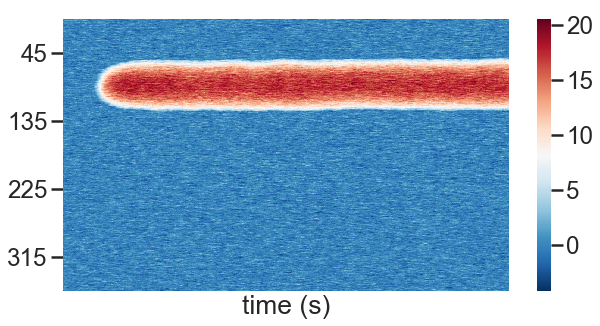

Simulation time: 7.1s
Gaussian fit


90.0

In [241]:

f = 1.2
an = model(totalTime=1500, targ_onset_1=100, targ_onset_2=800, angle_target_i=90, presentation_period=250,
           angle_separation=90, tauE=9, tauI=4,  n_stims=2, I0E=0.1, I0I=0.5, GEE=0.082, GEI=0.096, 
           GIE=0.042 , GII=0.108, sigE=2.5, sigI=2.5, kappa_E=40, kappa_I=1.5, kappa_stim=50, N=512, 
           plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False) 

abs_180_bias = an[0] ## 180-decode_rE(RE) measured that way
abs_180_bias

In [ ]:
GEE=0.025, GEI=0.019,  GIE=0.01 , GII=0.1,

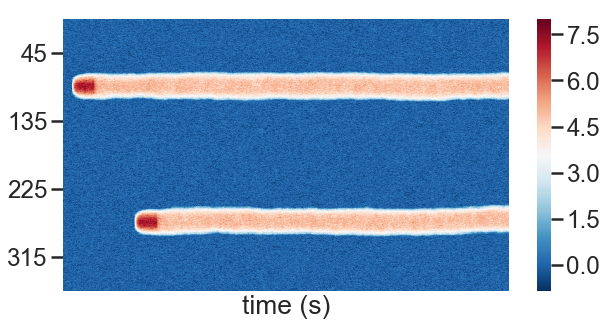

Simulation time: 18.7s
94.63521620591014


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in true_divide


-0.19930708800579566

In [136]:
an = model(totalTime=5000, targ_onset_1=100, targ_onset_2=800, angle_target_i=90, presentation_period=250,
           angle_separation=180, tauE=9, tauI=4,  n_stims=2, I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, 
           GIE=0.01 , GII=0.1, sigE=0.5, sigI=1.6, kappa_E=225, kappa_I=15, kappa_stim=75, N=512, 
           plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False) 

abs_180_bias = an[0] ## 180-decode_rE(RE) measured that way
abs_180_bias

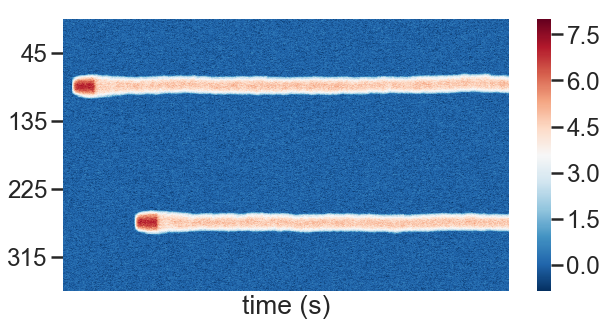

Simulation time: 17.5s
89.38855043570145


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in true_divide


-0.3649680699434654

In [137]:
an = model(totalTime=5000, targ_onset_1=100, targ_onset_2=800, angle_target_i=90, presentation_period=250,
           angle_separation=180, tauE=9, tauI=4,  n_stims=2, I0E=0.1, I0I=0.5, GEE=0.025, GEI=0.019, 
           GIE=0.01 , GII=0.1, sigE=0.5, sigI=1.6, kappa_E=300, kappa_I=30, kappa_stim=75, N=512, 
           plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False) 

abs_180_bias = an[0] ## 180-decode_rE(RE) measured that way
abs_180_bias

In [168]:
def model(totalTime, targ_onset_1, targ_onset_2, presentation_period, angle_target_i, angle_separation, tauE=9, tauI=4,  n_stims=2, I0E=0.1, I0I=0.5, GEE=0.022, GEI=0.019, 
 GIE=0.01 , GII=0.1, sigE=0.5, sigI=1.6, kappa_E=100, kappa_I=1.75, kappa_stim=100, N=512, plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=True):
    #
    st_sim =time.time()
    dt=2
    nsteps=int(floor(totalTime/dt));
    origin = np.radians(angle_target_i)
    rE=zeros((N,1));
    rI=zeros((N,1));
    #Connectivities
    v_E=zeros((N));
    v_I=zeros((N));
    WE=zeros((N,N));
    WI=zeros((N,N));
    separation =  np.radians(angle_separation)
    angle_target=angle_target_i
    angle_distractor=angle_target_i-angle_separation
    if n_stims==1:
        separation=0


    theta = [float(range(0,N)[i])/N*2*pi for i in range(0,N)] 
    for i in range(0, N):
        v_E_new=[e**(kappa_E*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]    
        v_I_new=[e**(kappa_I*cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) for f in range(0, len(theta))]
        ###    
        vE_NEW=roll(v_E_new,i)
        vI_NEW=roll(v_I_new,i) #to roll
        ###    
        WE[:,i]=vE_NEW
        WI[:,i]=vI_NEW
    #
    # Plot of the connectivity profile
    if plot_connectivity ==True:
        plt.figure()
        plt.plot(WE[250, :], label='E')
        plt.plot(WI[250, :], label = 'I')
        plt.ylim(0,6)
        plt.gca().spines['right'].set_visible(False) #no right axis
        plt.gca().spines['top'].set_visible(False) #no  top axis
        plt.gca().get_xaxis().tick_bottom()
        plt.gca().get_yaxis().tick_left()
        plt.show(block=False)
    ##
    # Stims
    if n_stims==2:
        stimulus1=zeros((N))
        stimulus2=zeros((N))
        for i in range(0, N):
            stimulus1[i]=e**(kappa_stim*cos(theta[i] + origin)) / (2*pi*scipy.special.i0(kappa_stim))
            stimulus2[i]=e**(kappa_stim*cos(theta[i] + origin + separation)) / (2*pi*scipy.special.i0(kappa_stim))
        #stimulus= (stimulus1 + stimulus2);
        #stimulus=reshape(stimulus, (N,1))
        stimulus_1=reshape(stimulus1, (N,1))
        stimulus_2=reshape(stimulus2, (N,1))
    elif n_stims==1:
        stimulus2=zeros((N));
        for i in range(0, N):
            stimulus2[i]=e**(kappa_stim*cos(theta[i] + origin)) / (2*pi*scipy.special.i0(kappa_stim))
        stimulus=stimulus2
        stimulus=reshape(stimulus, (N,1))
    ###
    ###
    stimon1 = floor(targ_onset_1/dt);
    stimoff1 = floor(targ_onset_1/dt) + floor(presentation_period/dt) ;
    stimon2 = floor(targ_onset_2/dt);
    stimoff2 = floor(targ_onset_2/dt) + floor(presentation_period/dt) ;
    #Simulation
    #generation of the noise and the connectivity between inhib and exit
    RE=zeros((N,nsteps));
    RI=zeros((N,nsteps));
    f = lambda x : x*x*(x>0)*(x<1) + reshape(array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real, (N,1)) * (x>=1)
    ### diferential equations
    for i in range(0, nsteps):
        noiseE = sigE*random.randn(N,1);
        noiseI = sigI*random.randn(N,1);
        #differential equations for connectivity
        IE= GEE*dot(WE,rE) - GIE*dot(WI,rI) + I0E*ones((N,1));
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1));
        #
        if i>stimon1 and i<stimoff1:
            IE=IE+stimulus_1;
            II=II+stimulus_1;
        if i>stimon2 and i<stimoff2:
            IE=IE+stimulus_2;
            II=II+stimulus_2;
        #
        #rates of exit and inhib
        rE = rE + (f(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (f(II) - rI + noiseI)*dt/tauI;
        rEr=reshape(rE, N)
        rIr=reshape(rI, N)
        #drawnow
        RE[:,i] = rEr;
        RI[:,i] = rIr;
    #
    ## metrics
    if n_stims==2:
        interference = Interference_effects( [decode_rE(stimulus1)], [decode_rE(rE)], [decode_rE(stimulus2)])[0]

    p_targ1 = int((N * np.degrees(origin + separation))/360)
    p_targ2 = int((N * np.degrees(origin - separation))/360)
    #
    if plot_rate==True:
        #### plot dynamics
        fig = plt.figure()
        plt.title('Rate dynamics')
        plt.plot(RE[p_targ1, :], 'b', label='target1')
        plt.plot(RE[p_targ2, :], 'r', label='target2')
        plt.xlabel('time (ms)')
        plt.ylabel('rate (Hz)')
        plt.legend()
        plt.show(block=False)
    if plot_hm==True:
        #### plot heatmap
        RE_sorted=flipud(RE)
        sns.set_context("poster", font_scale=1.1)
        sns.set_style("ticks")
        plt.figure(figsize=(10,5))
        #sns.heatmap(RE_sorted, cmap='binary', vmax=8)
        sns.heatmap(RE_sorted, cmap='RdBu_r')
        #plt.title('BUMP activity') # remove title
        #plt.ylabel('Angle')
        plt.xlabel('time (s)')
        #plt.ylim(int(3*N/8), int(5*N/8))
        #plt.plot([stimon, nsteps], [p_targ2, p_targ2], '--k', linewidth=2) ## flipped, so it is p_target 
        #plt.plot([stimon, nsteps], [p_targ1, p_targ1], '--r',) ## flipped, so it is p_target 
        plt.yticks([])
        plt.xticks([])
        plt.yticks([N/8, 3*N/8, 5*N/8, 7*N/8 ] ,['45','135','225', '315'])
        #plt.ylim( 3*N/8, 5*N/8)
        #plt.plot([stimon, stimon,], [0+20, N-20], 'k-', label='onset')
        #plt.plot([stimoff, stimoff,], [0+20, N-20], 'k--', label='offset')
        #plt.plot([stimon, stimon,], [0+20, N-20], 'k-', linewidth=0.5)
        #plt.plot([stimoff, stimoff,], [0+20, N-20], 'k-', linewidth=0.5)
        #plt.legend()
        plt.show(block=False)
    
    
    ## print time consumed
    end_sim =time.time()
    total_time= end_sim - st_sim 
    total_time = round(total_time, 1)
    print('Simulation time: ' + str(total_time) + 's')

    ###### Fit
    def von_misses(x,mu,k):
        return (exp( k * cos(x-mu))) / (2*pi*scipy.special.i0(k)) 

    def bi_von_misses(x,mu1,k1,mu2,k2):
        return von_misses(x,mu1,k1) + von_misses(x,mu2,k2)

    def gauss(x,mu,sigma,A):
        return A*exp(-(x-mu)**2/2/sigma**2)

    std_g = 999
    ##
    y=np.reshape(rE, (N)) 
    X=np.reshape(np.linspace(-pi, pi, N), N)

    ### Fit
    df_n_p=pd.DataFrame()
    df_n_p['rE'] = rE.reshape(512)
    peaks_list=[]
    for n_w_s in range(1, 100):
        r = df_n_p['rE'].rolling(window=n_w_s).mean()
        number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 
        peaks_list.append(number_of_bumps)
    #
    if number_of_bumps == 0:
        if peaks_list==[0 for i in range(len(peaks_list))]:
            number_of_bumps = 0
        else:
            peaks_list[:] = (value for value in peaks_list if value != 0)
            number_of_bumps=most_frequent(peaks_list)
    #
    number_of_bumps=most_frequent(peaks_list)
    #print(number_of_bumps)

    ### Fit
    #df_n_p=pd.DataFrame()
    #df_n_p['rE'] = rE.reshape(512)
    #r = df_n_p['rE'].rolling(window=20).mean()
    #number_of_bumps = len(scipy.signal.find_peaks(r, 2)[0]) 

    if number_of_bumps ==2:
        a1 = decode_rE(rE[:256])/2
        a2 = 180+decode_rE(rE[256:])/2
        print(a1)
        param, covs = curve_fit(bi_von_misses, X, y, p0=[separation, 75, -separation, 75], maxfev=10000)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) + (exp( param[3] * cos(X-param[2]))) / (2*pi*scipy.special.i0(param[3])) 
        estimated_angle_1=np.degrees(param[0]+pi)  
        estimated_angle_2=np.degrees(param[2]+pi)  
        estimated_angles = [estimated_angle_1, estimated_angle_2]
        estimated_angles.sort()
        bias_b1 = estimated_angles[0] -  np.degrees(origin - separation) ### change the error stuff
        bias_b2 =  np.degrees(origin + separation) - estimated_angles[1]
        final_bias = [bias_b1, bias_b2]
        skip_r_sq=False
        success=True
        decode_func = 0
        if n_stims==1:
            print('Error simultaion')
            bias_b1=999
            bias_b2=999
            estimated_angles=999
            final_bias=[999, 999]
            plot_fit=False
            skip_r_sq=True
            r_squared=0
            success=False ## to eliminate wrong simulations easily at the end
            decode_func = 0
        #
    #
    elif number_of_bumps ==1:
        param, covs = curve_fit(von_misses, X, y, maxfev=10000)
        ans = (exp( param[1] * cos(X-param[0]))) / (2*pi*scipy.special.i0(param[1])) 
        if param[0]<0:
            estimated_angles =decode_rE(rE)
            print('1 - with decode function')
            decode_func = 1
        else:
            estimated_angles=np.degrees(param[0]+pi) 
            decode_func = 0 
        #
        bias_b1 = estimated_angles - np.degrees( origin - separation)
        bias_b2 = np.degrees(origin + separation) - estimated_angles  ## bias (positive means attraction)
        ###final_bias = [bias_b1, bias_b2]  
        final_bias = [bias_b1, bias_b2] # de la otra manera estas forzando la media todo el rato
        skip_r_sq=False
        success=True
        print('Gaussian fit')
        param_g, covs_g = curve_fit(gauss, X, y, maxfev=10000)
        std_g = param_g[1]




        if n_stims==1:
            estimated_angles=np.degrees(param[0]+pi)
            bias_b1 = np.degrees(origin) - estimated_angles ## con fit
            bias_b2 = 180 - decode_rE(rE) ## scon decode_rE
            final_bias = [abs(bias_b2), abs(bias_b2)]
    ##
    else:
        print('Error simultaion')
        bias_b1=999
        bias_b2=decode_rE(rE)
        estimated_angles=999
        final_bias=[999, 999] #do not report a sign bias (it appears a an outlier furing the analysis)
        plot_fit=False ## do not plot the data when there is an error of the sim (maybe take off for some examples)
        skip_r_sq=True
        r_squared=0
        success=False ## to eliminate wrong simulations easily at the end
        decode_func = 0

    #error_fit (r_squared)
    if skip_r_sq==False:
        residuals = y - ans
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y-numpy.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)

    #plot fit
    if plot_fit==True:
        plt.figure()
        plt.plot(X, y, 'o', color ='red', label ="data") 
        plt.plot(X, ans, '--', color ='blue', label ="fit") 
        plt.legend() 
        plt.show(block=False) 
    ##
    ### Output
    total_sep=np.degrees(2*separation)
    final_bias = np.mean(final_bias)
    #print(total_sep)
    return(final_bias, bias_b1, bias_b2, rE, RE, estimated_angles, total_sep, kappa_E, kappa_I, r_squared, success, number_of_bumps, decode_func, std_g) #bias_b1, bias_b2)


###